In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, ttest_rel
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [81]:
import warnings

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [8]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [9]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_run = su.get_list_run()

In [10]:
dir_group = join(ssingle.get_dir_glmsingle(),'surfaceWB/group')
dir_group

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group'

---

In [11]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [12]:
dir_group = join(dir_surf,'group')

---

|(K,P)|ch $_{1}$|ch $_{2}$|$\cdots$|$i^{th}$ profile|$\cdots$|ch $_{P-1}$|ch $_{P}$| 
|-----|-----|-----|-----|-----|-----|-----|-----|
|cond $_{1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{2}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|$j^{th}$ pattern|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|cond $_{K-1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{K}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|

1) Whole Brain: Pattern Analysis
2) ROI: Profile Analysis

In [9]:
dir_roi = su.get_dir_roi()

In [10]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [11]:
fname = join(dir_roi, 'SPark.32k.L.dlabel.nii')
cii = nb.load(fname)
mask = cii.get_fdata()[0].astype(int)

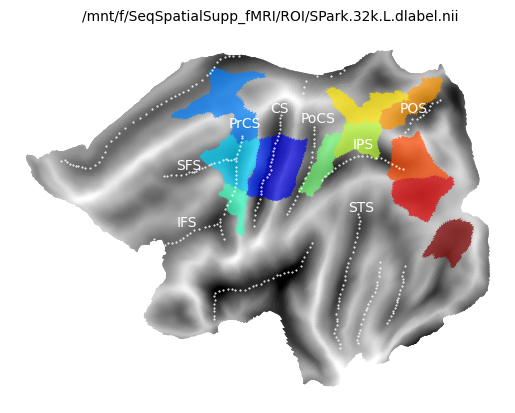

In [12]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

In [17]:
list_roi = ['S1','M1','SMA','PMd','PMv','SPLa','SPLp','BA7','POS','Dor','Mid','Ven']

---

In [46]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx].mean(axis=-1)

    return result

In [55]:
df = pd.DataFrame()

## 1. Overall Activity

In [56]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [57]:
glm = 1
category = 'overall'

In [58]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [59]:
for ii, cue in enumerate(['letter','spatial']):
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for jj, value in enumerate(values):
            sn = list_sn[jj]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

## 2. RS Effect

In [61]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [62]:
glm = 2
category = 'RS_effect'

In [63]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [64]:
for ii, cue in enumerate(['letter','spatial']):
    for jj, cond in enumerate(['wRS','acRS']):
        fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            for kk, value in enumerate(values):
                sn = list_sn[kk]
                subj = 'S'+sn
                lines['category'].append(category)
                lines['roi'].append(roi)
                lines['cond'].append('%s_%s'%(cond,cue))
                lines['subj'].append(subj)
                lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

## 3. RSA

In [93]:
def map_data2surf(data, mySearchlight):
    surf = np.ones((data.shape[0],32492)) * np.nan
    
    ## check the indeces of centers
    idx = mySearchlight.center_indx
    for ii, dd in enumerate(data):
        surf[ii,idx] = dd

    return surf

In [94]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[]}

In [95]:
glm = 1
category = 'RSA'

In [96]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [97]:
for jj, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn
    ## load the setup file
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=200.h5'%(subj,hem))
    mySearchlight = sl.load(fname)
    
    for ii, cue in enumerate(['letter','spatial']):    
        fname = join(dir_work,subj,'%s.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        data = map_data2surf(data=data, mySearchlight=mySearchlight)
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            value = values[0]
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

100%|███████████████████████████████████████████████████| 12/12 [06:16<00:00, 31.41s/it]


---

### i) Save the `df`

In [99]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df.to_csv(fname, index=False, encoding="utf-8")

### ii) Load the `df`

In [15]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df = pd.read_csv(fname, encoding="utf-8")

In [16]:
df

,category,roi,cond,subj,value
0,overall,S1,letter,S01,138.570632
1,overall,S1,letter,S02,112.226629
2,overall,S1,letter,S03,93.983156
3,overall,S1,letter,S05,190.969289
4,overall,S1,letter,S06,177.350423
...,...,...,...,...,...
1147,RSA,BA7,spatial,S14,0.001255
1148,RSA,POS,spatial,S14,0.000539
1149,RSA,Dor,spatial,S14,0.002731
1150,RSA,Mid,spatial,S14,0.004433


---

In [35]:
dg = df.pivot(index=['category','roi','cond'], columns=['subj'], values='value')
dg

subj                          S01         S02         S03         S05  \
category roi  cond                                                      
RSA      BA7  letter     0.001596    0.004733   -0.000135    0.000674   
              spatial   -0.000952   -0.001169    0.005584    0.004774   
         Dor  letter     0.004670   -0.002250   -0.004256    0.001692   
              spatial    0.004056    0.008034    0.002244    0.001796   
         M1   letter     0.000977   -0.004387   -0.000978    0.000979   
...                           ...         ...         ...         ...   
overall  SPLa spatial  100.333710  172.496560  219.192270  222.755544   
         SPLp letter    40.866936  138.504120  171.547566  208.784089   
              spatial  224.659797  109.857063  226.379830  269.356147   
         Ven  letter    63.302831  -15.328827   66.460715  -43.471912   
              spatial  267.170985  179.771425  308.807056   88.573795   

subj                          S06         S08         S09         S10  \
category roi  cond                                                      
RSA      BA7  letter    -0.000100   -0.000216    0.001372   -0.001432   
              spatial    0.001504   -0.000345   -0.000899    0.001507   
         Dor  letter    -0.000989    0.000861   -0.000091    0.000853   
              spatial    0.005449    0.001618    0.001039    0.003887   
         M1   letter    -0.000309    0.001218    0.000094   -0.001015   
...                           ...         ...         ...         ...   
overall  SPLa spatial  232.530609  112.081538  150.590955  192.386002   
         SPLp letter   242.530674  200.131206  150.663843  164.251371   
              spatial  266.753956  181.446087  202.315052  129.985819   
         Ven  letter   105.447062  -69.712059   31.947660  -81.345344   
              spatial  231.254608   79.104858  122.048058  173.432377   

subj                          S11         S12         S13         S14  
category roi  cond                                                     
RSA      BA7  letter     0.003561   -0.000493   -0.001545   -0.000102  
              spatial    0.001418   -0.004227    0.000357    0.001255  
         Dor  letter     0.003328    0.001351   -0.000021    0.001862  
              spatial    0.030264    0.002190    0.002009    0.002731  
         M1   letter    -0.000802    0.000540    0.001701    0.004928  
...                           ...         ...         ...         ...  
overall  SPLa spatial  216.875786  235.189464   84.835458  150.023196  
         SPLp letter    60.562173  310.214358  185.991729  204.642438  
              spatial   97.212842  311.968887  198.607255  266.073811  
         Ven  letter   -18.478262   -4.254523  -77.246686  -12.418095  
              spatial  210.025287  178.171195  258.611309   99.937464  

[96 rows x 12 columns]

In [48]:
dg_norm = dg.sub(dg.min(axis=1), axis=0).div(dg.max(axis=1) - dg.min(axis=1), axis=0)
dg_norm

subj                        S01       S02       S03       S05       S06  \
category roi  cond                                                        
RSA      BA7  letter   0.500207  1.000000  0.224581  0.353377  0.230051   
              spatial  0.333755  0.311703  1.000000  0.917437  0.584128   
         Dor  letter   1.000000  0.224743  0.000000  0.666445  0.366085   
              spatial  0.103216  0.239329  0.041223  0.025898  0.150900   
         M1   letter   0.575867  0.000000  0.365910  0.576023  0.437791   
...                         ...       ...       ...       ...       ...   
overall  SPLa spatial  0.103078  0.583031  0.893603  0.917302  0.982316   
         SPLp letter   0.000000  0.362495  0.485175  0.623422  0.748712   
              spatial  0.593450  0.058877  0.601459  0.801576  0.789459   
         Ven  letter   0.774379  0.353422  0.791285  0.202757  1.000000   
              spatial  0.818739  0.438248  1.000000  0.041223  0.662378   

subj                        S08       S09       S10       S11       S12  \
category roi  cond                                                        
RSA      BA7  letter   0.211597  0.464595  0.018013  0.813292  0.167586   
              spatial  0.395681  0.339215  0.584484  0.575328  0.000000   
         Dor  letter   0.573250  0.466604  0.572429  0.849649  0.628149   
              spatial  0.019804  0.000000  0.097435  1.000000  0.039377   
         M1   letter   0.601686  0.480971  0.361948  0.384874  0.528949   
...                         ...       ...       ...       ...       ...   
overall  SPLa spatial  0.181213  0.437338  0.715315  0.878196  1.000000   
         SPLp letter   0.591297  0.407640  0.458087  0.073122  1.000000   
              spatial  0.392228  0.489403  0.152606  0.000000  1.000000   
         Ven  letter   0.062279  0.606518  0.000000  0.336561  0.412709   
              spatial  0.000000  0.186952  0.410651  0.569957  0.431282   

subj                        S13       S14  
category roi  cond                         
RSA      BA7  letter   0.000000  0.229740  
              spatial  0.467259  0.558723  
         Dor  letter   0.474441  0.685460  
              spatial  0.033163  0.057875  
         M1   letter   0.653572  1.000000  
...                         ...       ...  
overall  SPLa spatial  0.000000  0.433562  
         SPLp letter   0.538801  0.608046  
              spatial  0.472138  0.786292  
         Ven  letter   0.021942  0.369005  
              spatial  0.781475  0.090694  

[96 rows x 12 columns]

In [49]:
df_norm = dg_norm.reset_index().melt(
    id_vars=['category','roi','cond'],
    var_name='subj',
    value_name='value'
)
df_norm

,category,roi,cond,subj,value
0,RSA,BA7,letter,S01,0.500207
1,RSA,BA7,spatial,S01,0.333755
2,RSA,Dor,letter,S01,1.000000
3,RSA,Dor,spatial,S01,0.103216
4,RSA,M1,letter,S01,0.575867
...,...,...,...,...,...
1147,overall,SPLa,spatial,S14,0.433562
1148,overall,SPLp,letter,S14,0.608046
1149,overall,SPLp,spatial,S14,0.786292
1150,overall,Ven,letter,S14,0.369005


In [79]:
list_roi = ['S1','M1','SMA','PMd','PMv','SPLa','SPLp','BA7','POS','Dor','Mid','Ven']
# list_roi = ['S1']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.17it/s]


S1 t(11)=5.7237, p=6.672e-05(****)
S1 t(11)=6.0688, p=4.045e-05(****)
S1 t(11)=8.4501, p=1.934e-06(****)
S1 t(11)=5.6945, p=6.966e-05(****)
S1 t(11)=5.2201, p=1.427e-04(***)
S1 t(11)=6.0495, p=4.158e-05(****)
S1 t(11)=3.9212, p=1.194e-03(**)
S1 t(11)=4.4192, p=5.149e-04(***)
M1 t(11)=6.7627, p=1.552e-05(****)
M1 t(11)=7.1806, p=8.984e-06(****)
M1 t(11)=6.4294, p=2.439e-05(****)
M1 t(11)=5.8169, p=5.818e-05(****)
M1 t(11)=4.2740, p=6.560e-04(***)
M1 t(11)=6.3836, p=2.599e-05(****)
M1 t(11)=7.3716, p=7.047e-06(****)
M1 t(11)=2.1469, p=2.747e-02(*)
SMA t(11)=7.1122, p=9.810e-06(****)
SMA t(11)=7.1109, p=9.826e-06(****)
SMA t(11)=6.9668, p=1.185e-05(****)
SMA t(11)=5.5504, p=8.632e-05(****)
SMA t(11)=7.4022, p=6.780e-06(****)
SMA t(11)=9.0182, p=1.028e-06(****)
SMA t(11)=3.7044, p=1.737e-03(**)
SMA t(11)=4.3032, p=6.246e-04(***)
PMd t(11)=6.2579, p=3.096e-05(****)
PMd t(11)=6.4094, p=2.507e-05(****)
PMd t(11)=8.2512, p=2.431e-06(****)
PMd t(11)=5.5342, p=8.845e-05(****)
PMd t(11)=4.5483, p

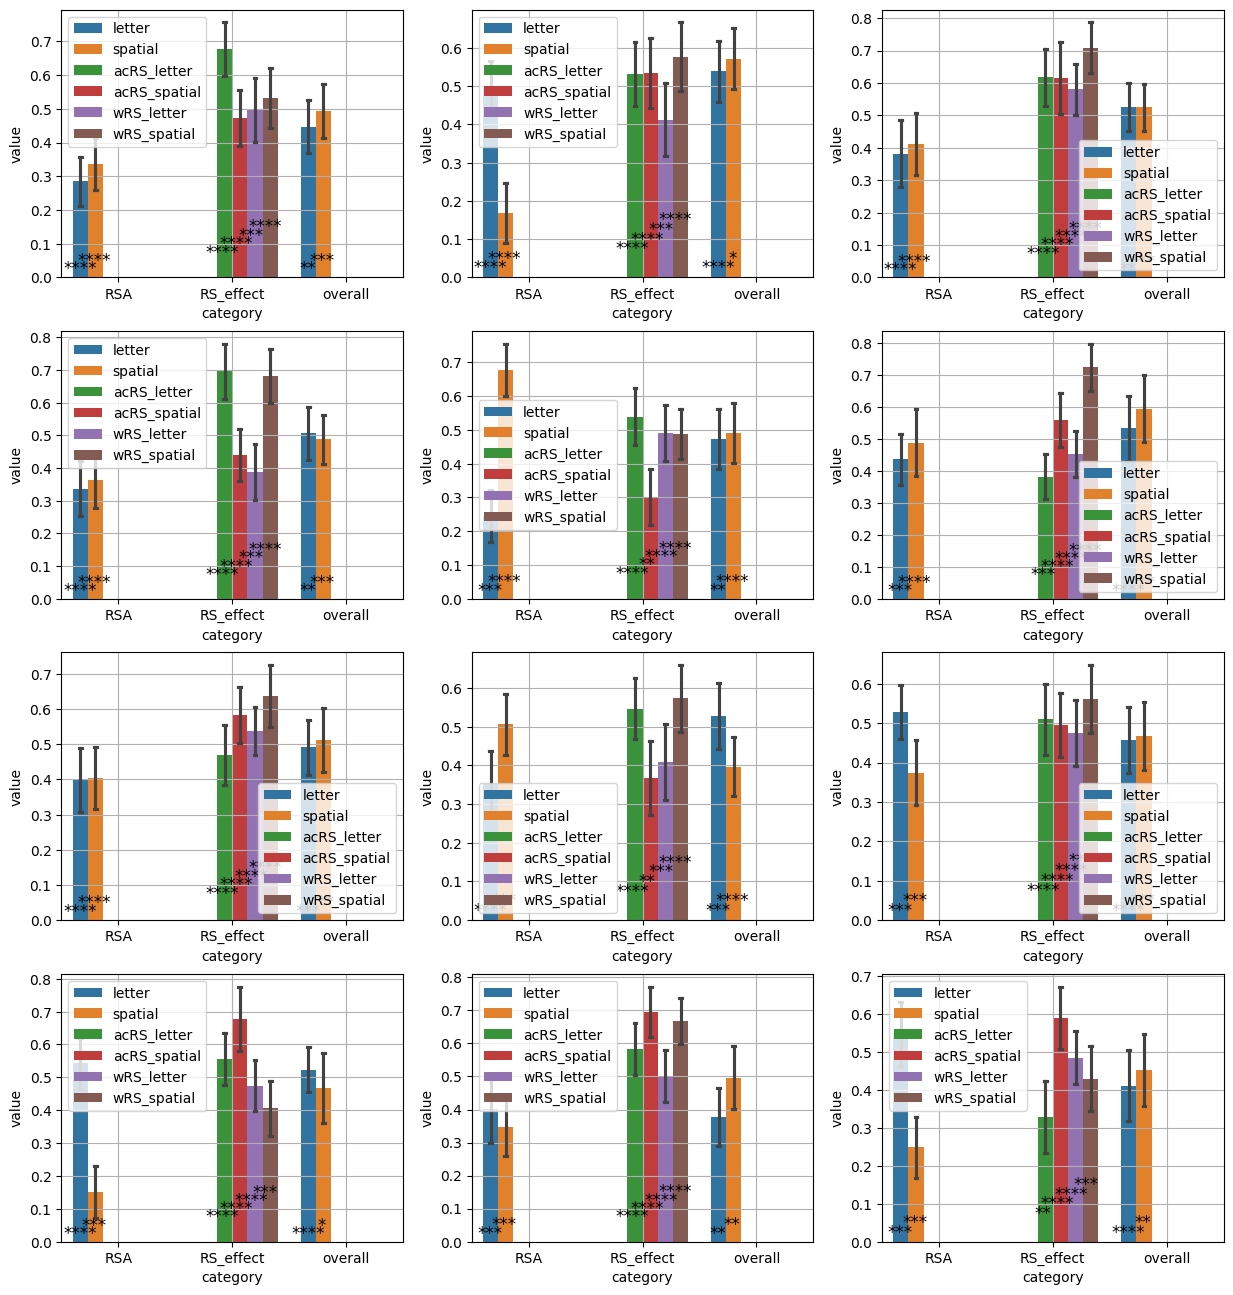

In [88]:
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
axs = np.concatenate(axs)

for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    g = sns.barplot(
        data=df_norm[df_norm.roi==roi],
        x='category', y='value', hue='cond',
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.set_ylim(-0.01,0.01)
    g.grid(axis='both')
    g.legend()

## one sample t-test
dx = 1./8
dy = 0.025
for ii, roi in enumerate(list_roi):
    ax = axs[ii]
    for jj, category in enumerate(['overall','RS_effect','RSA']):
        for kk, cond in enumerate(['letter','spatial','acRS_letter','acRS_spatial','wRS_letter','wRS_spatial']):
            x = jj + dx*kk - 2.7*dx
            back2 = True
            if category=='RS_effect':
                if (cond!='letter')&(cond!='spatial'):
                    back2 = False
            else:
                if (cond=='letter')|(cond=='spatial'):
                    back2 = False
            if back2:
                continue
            a = df_norm[(df_norm.roi==roi)&(df_norm.category==category)&(df_norm.cond==cond)].value.astype(float)
            res = ttest_1samp(a=a, popmean=0, alternative='greater')
            if res.pvalue < 0.05:
                print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                # y = a.mean()+a.sem()
                y = 0.025 + kk*dy
                ax.text(
                    x=x, y=y,
                    s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                    color='black',
                    ha='center', va='center'
                )

---